In [26]:
import glob

all_filenames = glob.glob('./dataset/data/names/*.txt')
print(all_filenames)

['./dataset/data/names/Arabic.txt', './dataset/data/names/Chinese.txt', './dataset/data/names/Czech.txt', './dataset/data/names/Dutch.txt', './dataset/data/names/English.txt', './dataset/data/names/French.txt', './dataset/data/names/German.txt', './dataset/data/names/Greek.txt', './dataset/data/names/Irish.txt', './dataset/data/names/Italian.txt', './dataset/data/names/Japanese.txt', './dataset/data/names/Korean.txt', './dataset/data/names/Polish.txt', './dataset/data/names/Portuguese.txt', './dataset/data/names/Russian.txt', './dataset/data/names/Scottish.txt', './dataset/data/names/Spanish.txt', './dataset/data/names/Vietnamese.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
print('n_categories =', n_categories)

n_categories = 18


In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
import torch

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

In [6]:
print(letter_to_tensor('J'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])


In [7]:
print(line_to_tensor('Jones').size())

torch.Size([5, 1, 57])


In [8]:
from torch import nn
from torch.autograd import Variable

class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        out = self.fc(out[-1])
        return out, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)


n_hidden = 128
rnn = MyRNN(n_letters, n_hidden, n_categories)

In [12]:
# rnn = nn.RNN(10, 20, 1)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(1, 3, 20)
# output, hn = rnn(input, h0)
# print(output.size(), hn.size())

torch.Size([5, 3, 20]) torch.Size([1, 3, 20])


In [9]:
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0:3], hidden)
print('output.size =', output.size())
print(output)

output.size = torch.Size([1, 18])
tensor([[-0.0679, -0.0016,  0.0725,  0.0135, -0.0289, -0.1219,  0.0894, -0.0513,
         -0.1230, -0.0168, -0.0281,  0.0885,  0.1141,  0.0011,  0.1258,  0.0274,
         -0.0056, -0.0495]], grad_fn=<AddmmBackward>)


In [10]:
input = line_to_tensor('Albert')
hidden = rnn.init_hidden()

output, next_hidden = rnn(input[0:1], hidden)
output, next_hidden = rnn(input[1:2], next_hidden)
output, next_hidden = rnn(input[2:3], next_hidden)
print('output.size =', output.size())
print(output)

output.size = torch.Size([1, 18])
tensor([[-0.0679, -0.0016,  0.0725,  0.0135, -0.0289, -0.1219,  0.0894, -0.0513,
         -0.1230, -0.0168, -0.0281,  0.0885,  0.1141,  0.0011,  0.1258,  0.0274,
         -0.0056, -0.0495]], grad_fn=<AddmmBackward>)


In [25]:
rnn = nn.RNN(3, 5, 1)
input = torch.randn(6, 1, 3)
h0 = torch.randn(1, 1, 5)
output, hn = rnn(input, h0)
print(output.size(), hn.size())
print(output)
print(hn)

torch.Size([6, 1, 5]) torch.Size([1, 1, 5])
tensor([[[ 0.9899,  0.1842, -0.0149, -0.8694,  0.4499]],

        [[-0.1052, -0.8922,  0.2761, -0.0296, -0.5678]],

        [[ 0.3770, -0.8517,  0.3580,  0.5489,  0.2375]],

        [[-0.1232, -0.5432, -0.3956,  0.7539,  0.2906]],

        [[ 0.6723, -0.9468,  0.7891, -0.5991, -0.7210]],

        [[-0.2315, -0.7817,  0.1516,  0.8883,  0.6130]]],
       grad_fn=<StackBackward>)
tensor([[[-0.2315, -0.7817,  0.1516,  0.8883,  0.6130]]],
       grad_fn=<StackBackward>)


In [11]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i
print(category_from_output(output))

('Russian', tensor(14))


In [12]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = Spanish / line = Quinones
category = German / line = Gerber
category = Japanese / line = Shikuk
category = Scottish / line = Macleod
category = Japanese / line = Erizawa
category = German / line = Krantz
category = Polish / line = Stawski
category = Czech / line = Doljs
category = Irish / line = Sluaghadhan
category = German / line = Herbert


In [13]:
criterion = nn.CrossEntropyLoss()

In [14]:
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [15]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    output, hidden = rnn(line_tensor, hidden)
    loss = criterion(output, category_tensor)
    #for i in range(line_tensor.size()[0]):
    #    output, hidden = rnn(line_tensor[i:i+1], hidden)
    #loss = criterion(output, category_tensor)
    
    loss.backward()
    
    optimizer.step()
    
    return output, loss.item()

In [16]:
import time
import math

n_epochs = 300000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    # Get a random training input and target
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print epoch number, loss, name and guess
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 1% (0m 4s) 3.3007 Saji / Korean ✗ (Japanese)
10000 3% (0m 8s) 2.1797 Lysenko / Italian ✗ (Russian)
15000 5% (0m 12s) 2.0207 Pae / Chinese ✗ (Korean)
20000 6% (0m 17s) 2.0458 Tze / Korean ✗ (Chinese)
25000 8% (0m 21s) 0.2896 Andrysiak / Polish ✓
30000 10% (0m 25s) 0.2468 Anderson / Scottish ✓
35000 11% (0m 29s) 0.2406 Sarraf / Arabic ✓
40000 13% (0m 34s) 0.6226 Zhang / Chinese ✓
45000 15% (0m 38s) 1.2206 Brauer / German ✓
50000 16% (0m 42s) 0.3973 Zientek / Polish ✓
55000 18% (0m 47s) 0.7386 Seto / Chinese ✓
60000 20% (0m 51s) 4.8692 Morri / Italian ✗ (Japanese)
65000 21% (0m 55s) 1.8922 Simon / Irish ✗ (Dutch)
70000 23% (0m 59s) 0.1284 Palladino / Italian ✓
75000 25% (1m 4s) 2.4202 Chong / Vietnamese ✗ (Korean)
80000 26% (1m 8s) 0.1171 Kozlow / Polish ✓
85000 28% (1m 12s) 0.9793 Borghi / Japanese ✗ (Italian)
90000 30% (1m 16s) 0.5006 Sartre / French ✓
95000 31% (1m 21s) 0.8678 Furst / German ✓
100000 33% (1m 25s) 0.2380 Dziadik / Czech ✓
105000 35% (1m 29s) 1.9441 Bilias / Czech ✗

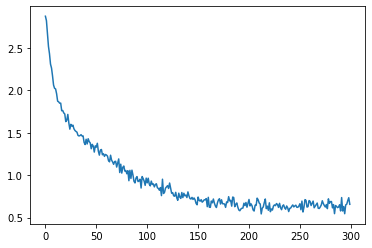

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

<ipython-input-18-8df22caf34eb>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-18-8df22caf34eb>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


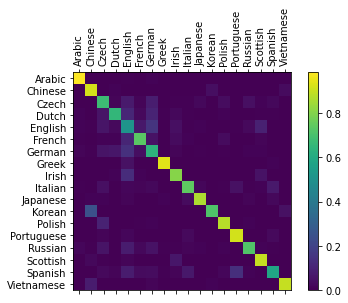

In [18]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    output, hidden = rnn(line_tensor, hidden)
    #for i in range(line_tensor.size()[0]):
    #    output, hidden = rnn(line_tensor[i:i+1], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

<ipython-input-19-eebe9349d529>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-19-eebe9349d529>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


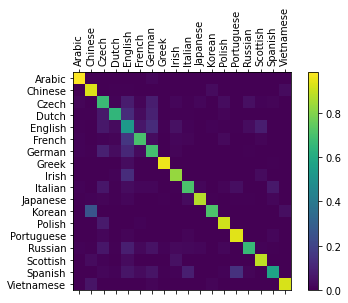

In [19]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    #output, hidden = rnn(line_tensor, hidden)
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i:i+1], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()



---

In [1]:
import glob
import os
import unicodedata
import string

In [2]:
all_letters = string.ascii_letters + " ,.;'-"
n_letters = len(all_letters) + 1

In [3]:
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [4]:
def readLines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicodeToAscii(line.strip()) for line in f]
    
category_lines = {}
all_categories = []

for filename in findFiles('./dataset/data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('# categories:', n_categories, all_categories)

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [79]:
fc = nn.Linear(10, 3)
input = torch.rand(3, 2, 10)
output = fc(input)
print(output)

target = torch.tensor([[0, 1, 1], [1, 0, 1], [1, 1, 0]], dtype=torch.long)
loss = nn.CrossEntropyLoss()

l = loss(output, target)
l.backward()
print(l)
print(fc.weight.grad)

tensor([[[-0.0523, -0.4751,  0.0505],
         [-0.3998, -0.2424,  0.1636]],

        [[ 0.1136, -0.3510,  0.1546],
         [-0.2555, -0.4396,  0.0487]],

        [[-0.4645, -0.2324, -0.0772],
         [-0.1068, -0.4025,  0.4067]]], grad_fn=<AddBackward0>)
tensor(0.7027, grad_fn=<NllLoss2DBackward>)
tensor([[ 0.0004,  0.0321,  0.0120, -0.0485,  0.0009,  0.0072, -0.0264, -0.0194,
          0.0134, -0.0035],
        [-0.0180,  0.0263,  0.0323, -0.0254,  0.0212,  0.0617,  0.0631,  0.0075,
          0.0025,  0.0622],
        [ 0.0568, -0.0433, -0.0200,  0.1126,  0.0317, -0.0490, -0.0358,  0.0555,
          0.0875, -0.0139]])


In [80]:
fc.zero_grad()

output = torch.stack([fc(i) for i in input], 0)
print(output)

#l = torch.sum([loss(o, t) for o, t in zip(output, target)])
#l.backward()

#print(fc.weight.grad)

tensor([[[-0.0523, -0.4751,  0.0505],
         [-0.3998, -0.2424,  0.1636]],

        [[ 0.1136, -0.3510,  0.1546],
         [-0.2555, -0.4396,  0.0487]],

        [[-0.4645, -0.2324, -0.0772],
         [-0.1068, -0.4025,  0.4067]]], grad_fn=<StackBackward>)


In [90]:
fc.zero_grad()

output = torch.stack([fc(input[:,i,:]) for i in range(input.size(1))], 1)
print(output)

l = torch.sum(torch.stack([loss(output.swapaxes(0,1)[i], target.swapaxes(0,1)[i]) for i in range(input.size(1))]))
l.backward()
print(l)
print(fc.weight.grad)

tensor([[[-0.0523, -0.4751,  0.0505],
         [-0.3998, -0.2424,  0.1636]],

        [[ 0.1136, -0.3510,  0.1546],
         [-0.2555, -0.4396,  0.0487]],

        [[-0.4645, -0.2324, -0.0772],
         [-0.1068, -0.4025,  0.4067]]], grad_fn=<StackBackward>)
tensor(2.4808, grad_fn=<SumBackward0>)
tensor([[ 0.0455,  0.0209, -0.0596, -0.1032, -0.0136, -0.1299, -0.0956, -0.0121,
         -0.0131, -0.1578],
        [-0.3888, -0.4810, -0.3631, -0.3243, -0.4702, -0.2636, -0.3845, -0.5799,
         -0.3260, -0.2694],
        [ 0.3434,  0.4601,  0.4227,  0.4275,  0.4838,  0.3936,  0.4801,  0.5920,
          0.3391,  0.4272]])


In [5]:
import torch
from torch import nn

class MyRNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        out, hidden = self.rnn(input, hidden)
        #out = torch.stack([self.fc(o) for o in out])
        out = self.fc(out)
        return out, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [6]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [7]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [8]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    # print(category_tensor.size(), input_line_tensor.size())
    return torch.cat((torch.stack([category_tensor] * input_line_tensor.size(0)), input_line_tensor), 2), target_line_tensor

In [36]:
criterion = nn.CrossEntropyLoss(reduction='sum') #改用sum才不會讓短的文字learning rate比較大
learning_rate = 0.0005

def train(input_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    loss = 0
    
    output, hidden = rnn(input_tensor, hidden)
    output = output.swapaxes(1, 2)
    #print(output.size(), target_line_tensor.size())
    loss = criterion(output, target_line_tensor)
    
    #for i in range(input_tensor.size(0)):
    #    l = criterion(output[i], target_line_tensor[i])
    #    loss += l
    
    #output.squeeze_(1)
    #target_line_tensor.squeeze_(1)
    #print(output.size(), target_line_tensor.size())
    #loss = criterion(output, target_line_tensor)
    
    
    #for i in range(input_tensor.size(0)):
    #    output, hidden = rnn(input_tensor[i:i+1], hidden)
        #print(output.size(), target_line_tensor.size())
    #    output.squeeze_(0)
        #print(output.size(), target_line_tensor.size())

    #    l = criterion(output, target_line_tensor[i])
    #    loss += l
    
    
    #l.backward()
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    #return output, l.item() / input_tensor.size(0)
    return output, loss.item() / input_tensor.size(0)

In [37]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [38]:
rnn = MyRNN2(n_categories + n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 2.5165
0m 9s (10000 10%) 2.2577
0m 13s (15000 15%) 3.7505
0m 17s (20000 20%) 2.6485
0m 22s (25000 25%) 2.5197
0m 26s (30000 30%) 1.9040
0m 31s (35000 35%) 2.6226
0m 35s (40000 40%) 2.9783
0m 40s (45000 45%) 2.1848
0m 44s (50000 50%) 1.7740
0m 49s (55000 55%) 1.8875
0m 53s (60000 60%) 2.2630
0m 58s (65000 65%) 1.7307
1m 2s (70000 70%) 1.9339
1m 7s (75000 75%) 1.9890
1m 11s (80000 80%) 2.5054
1m 16s (85000 85%) 1.4749
1m 20s (90000 90%) 2.2770
1m 25s (95000 95%) 2.7747
1m 29s (100000 100%) 2.6230


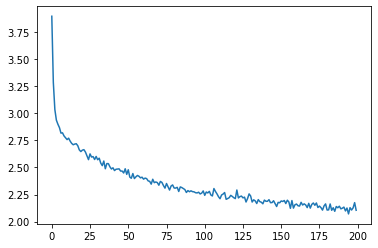

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)


In [40]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        category_tensor.unsqueeze_(0)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            #print(category_tensor.size(), input.size())
            newInput = torch.cat((category_tensor, input), 2)
            output, hidden = rnn(newInput, hidden)
            #print(output.size())
            topv, topi = output.topk(1)
            #print(topv, topi)
            topi = topi[0][0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')


Rovakov
Uarakov
Shavavev
Garter
Erere
Rour
Sara
Para
Aras
Chang
Han
Iun
